In [96]:
# | echo: true
# | output: false
# | warning: false

from numbers import Number
from typing import Mapping

"in the following cell, override the default pipeline parameters if needed"

# QC Params

# check QC and filter cells for each sample separately, default: True.
QC_PER_SAMPLE: bool = True

# Correct ambient RNA, uses DecontX.
CORRECT_AMBIENT_RNA: bool = False

# Filter doublets using Scrublet
FILTER_DOUBLETS: bool = False

# Calculate cell cycle scores, based on scanpy implementation.
CELL_CYCLE_SCORE: bool = True


############################################################
####################     QC dict      ######################
############################################################
qc_dict: dict[str, list] | dict[str, Number] = {
    "n_genes_by_counts": 5,
    "total_counts": 5,
    "pct_counts_mt": 3,
}  # type: ignore

# MODIFY_ME, Specifiy only after running diagnotics on the samples
# global config
# qc_dict: dict[str, list] | dict[str, list] = {
#     "pct_counts_mt": [0, 10],
#     "pct_counts_rb": [0, 10],
#     "n_genes_by_counts": [1500, 9000],
#     "total_counts": [3_000, 40_000]
# }


# # per-sample config
# qc_dict: dict[str, list] | dict[str, list] = {
#     "sample1": {
#         "pct_counts_mt": [0, 10],
#         "pct_counts_rb": 5,
#         "total_counts": [3_000, 40_000]
#     },
#     "sample2": {
#         "pct_counts_rb": 3,
#         "n_genes_by_counts": [1500, 9000],
#         "total_counts": [3_000, 40_000]
#     },
#     "sample3": {
#         "pct_counts_mt": [0, 10],
#         "n_genes_by_counts": [1500, 9000],
#         "total_counts": [3_000, 40_000]
#     },
#     "sample4": {
#         "pct_counts_mt": 4
#         "pct_counts_rb": 5,
#         "n_genes_by_counts": 6,
#     }
# }

In [1]:
# | echo: false
# | output: false
# | warning: false

import logging
from collections.abc import Callable
from functools import reduce
from numbers import Number
from operator import add
from os import cpu_count, listdir, mkdir, path, walk

import anndata as ad
import hvplot.pandas
import itables
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import panel as pn
import scanpy as sc
import seaborn as sns
import session_info
import tomlkit
import utils.preprocessing_funcs as pf
from matplotlib import rc_context
from utils.autodiscover import AutoDiscover, discover_factory

logging.basicConfig(level=logging.ERROR)
sc.set_figure_params(dpi=100, dpi_save=300, format="png")
sc.settings.n_jobs = int(cpu_count() * 0.8)
pn.extension()

In [97]:
# | echo: false
# | output: false
# | warning: false

# Pipeline parameters
with open("../config.toml", "r") as f:
    config = tomlkit.parse(f.read())

In [98]:
# | echo: false
# | output: false
# | warning: false


# Directories
ROOT_DIR = config["basic"]["ANALYSIS_DIR"]
DIR_SAVE = path.join(ROOT_DIR, config["basic"]["DIR_SAVE"])
DIR_samples = config["basic"]["DIR_SAMPLES"]

# Basic information
TECHNOLOGY: str = config["basic"]["TECHNOLOGY"]
ORGANISM: str = config["basic"]["ORGANISM"]
AUTODISCOVER: bool = config["basic"]["auto_find"]
samples: dict[str, str] = config["basic"]["samples"]
raw_samples: dict[str, str] = config["basic"]["raw_samples"]

# MAX_ONLY: ignores the lower bound.
# LOG_TRANSFORMED: applies log1p transformation for the given columns.
MAX_ONLY: list[str] = ["pct_counts_mt", "pct_counts_rb", "pct_counts_hb"]
LOG_TRANSFORMED: list[str] = ["total_counts", "n_genes_by_counts"]

In [99]:
# | echo: false
# | output: false
# | warning: false


plotting_qc_keys = pf.get_keys(qc_dict)

if len(pf.get_keys(qc_dict)) == 0:
    raise ValueError("Couldn't get valid qc variables from QC dict.")

filter_qc_keys = plotting_qc_keys

plotting_qc_keys = plotting_qc_keys + ["pct_counts_rb"]

if FILTER_DOUBLETS and "doublet_score" not in plotting_qc_keys:
    plotting_qc_keys = plotting_qc_keys + ["doublet_score"]

if CORRECT_AMBIENT_RNA and "decontX_contamination" not in plotting_qc_keys:
    plotting_qc_keys = plotting_qc_keys + ["decontX_contamination"]

if CELL_CYCLE_SCORE and "S_score" not in plotting_qc_keys:
    plotting_qc_keys = plotting_qc_keys + ["S_score"]

if CELL_CYCLE_SCORE and "G2M_score" not in plotting_qc_keys:
    plotting_qc_keys += ["G2M_score"]


sample_cls: type[AutoDiscover] = discover_factory[TECHNOLOGY]
sample_utils = sample_cls(DIR_samples)

In [100]:
# | echo: false
# | warning: false

# Diagnosic pipeline
## Reading files

# TODO: Refactor to a better design, use a custom function for discovery.
if AUTODISCOVER and len(samples) == 0:
    samples: dict[str, str] = sample_utils.get_samples()
    read_function: Callable = sample_utils.read_function()
else:
    samples = config["basic"]["samples"]
    read_function = sample_utils.read_function(samples)
    if len(samples) == 0:
        raise RuntimeError(
            "No samples paths were provided, provide sample paths as a dictionary in 'config.toml'"
        )

# Samples

In [9]:
# | warning: false
itables.show(pd.DataFrame(samples, index=["sample path"]).T)

In [ ]:
# | echo: false
# | output: false
# | warning: false


adatas = {}
for sample_id, filename in samples.items():
    sample_adata = read_function(filename)
    sample_adata.var_names_make_unique()
    adatas[sample_id] = sample_adata

adata = ad.concat(adatas, label="sample", join="outer", merge="same")
adata.obs_names_make_unique()
del adatas

if TECHNOLOGY == "10x" and CORRECT_AMBIENT_RNA:
    adatas_raw = {}
    if AUTODISCOVER:
        raw_samples: dict[str, str] = sample_utils.get_raw_samples()
        raw_read_fun = sample_utils.raw_read_function()
    else:
        raw_read_fun = sample_utils.raw_read_function(raw_samples)

    for sample_id, filename in raw_samples.items():  # type: ignore
        raw = read_function(filename)
        raw.var_names_make_unique()
        adatas_raw[sample_id] = raw

    adata_raw = ad.concat(adatas_raw, label="sample", join="outer", merge="same")
    adata_raw.obs_names_make_unique()
    del adatas_raw

In [10]:
## Remove

adata = sc.read_h5ad("../save/adata.h5ad")
adata

AnnData object with n_obs × n_vars = 31087 × 36601
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'log1p_total_counts_rb', 'pct_counts_rb', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes_by_counts_outlier', 'total_counts_outlier', 'pct_counts_mt_outlier', 'outlier', 'S_score', 'G2M_score', 'phase', 'groups', 'leiden_1.0', 'scTAB_annotation', 'scTAB_annotation_majority_voting'
    var: 'gene_ids', 'feature_types', 'mt', 'rb', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'CLUSTERING_COL', 'FINAL_CLUSTERED', 'groups', 'hvg', 'leiden_0.1', 'leiden_0.1_colors', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'leiden_0.5', 'le

In [35]:
## Remove
adata = sc.read_h5ad("../save/adata.h5ad")
adata_raw = sc.read_h5ad("../save/raw_adata.h5ad")

In [106]:
# | echo: false
# | output: false
# | warning: false

## Adding quality metrics
mt_features = pf.qc_features_rules[ORGANISM]["mito"]
rb_features = pf.qc_features_rules[ORGANISM]["ribo"]
hb_features = pf.qc_features_rules[ORGANISM]["hb"]

# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith(tuple(mt_features))
# ribosomal genes
adata.var["rb"] = adata.var_names.str.startswith(tuple(rb_features))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains(
    tuple(hb_features)[0]
)  # Only regex is accepted

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "rb", "hb"], percent_top=[20], inplace=True, log1p=False
)

In [107]:
# | echo: false
# | output: false
# | warning: false


# Validate QC dict
if not pf.validate_qc_dict(qc_dict, adata.obs):
    raise ValueError("Invalid QC dict, check the keys and values in the QC dict.")

# Convert global qc_dict to per-sample qc_dict
if QC_PER_SAMPLE:
    if all(map(lambda x: isinstance(x, (list, Number)), qc_dict.values())):
        qc_dict = {sample: qc_dict for sample in adata.obs["sample"].unique()}

if QC_PER_SAMPLE:
    outlier_results = []
    for sample_id in adata.obs["sample"].unique():
        sample_obs: pd.DataFrame = adata.obs.query("sample == @sample_id")
        sample_outliers: pd.DataFrame = pf.compute_outliers(
            sample_obs, qc_dict[sample_id], MAX_ONLY, LOG_TRANSFORMED
        )
        outlier_results.append(sample_outliers)
    adata.obs = pd.concat(outlier_results)

else:
    adata.obs = pf.compute_outliers(adata.obs, qc_dict, MAX_ONLY, LOG_TRANSFORMED)

In [ ]:
# | echo: false
# | output: false
# | warning: false


## Ambient RNA correction
# TODO: Check if the Ambient RNA can be improved by using Batch information?

if CORRECT_AMBIENT_RNA and TECHNOLOGY == "10x":
    import tempfile
    from os import path, system

    with tempfile.TemporaryDirectory(dir=".") as tmpdirname:

        # Workaround failure of GenomeInfoDb to install in Pixi
        pf.GenomeInfoDB_fix(tmpdirname)
        # Define paths for temporary files
        sce_path = path.join(tmpdirname, "sce.h5ad")
        raw_path = path.join(tmpdirname, "raw.h5ad")
        decontx_path = path.join(tmpdirname, "decontX.h5ad")

        # Save adata and adata_raw to the temporary directory
        adata.write_h5ad(sce_path)
        adata_raw.write_h5ad(raw_path)

        # Execute R scripts with temporary file paths
        system(
            f"Rscript ./utils/deconx.R -s {sce_path} -r {raw_path} -o {decontx_path}"
        )

        # Read the result back from the temporary directory
        adata = sc.read_h5ad(decontx_path)

In [ ]:
# | echo: false
# | output: false
# | warning: false

## Doublet Detection

# TODO: Check real-life performance
# TODO: Check Interop with R to convert object to R & vice-versa
if FILTER_DOUBLETS and TECHNOLOGY == "10x":
    sc.pp.scrublet(adata, batch_key="sample")

In [ ]:
# | echo: false
# | output: false
# | warning: false

## Cell cycle Scoring
# **Not reliable, do via interop later**

adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.scale(adata)


if CELL_CYCLE_SCORE:
    if ORGANISM in ["human", "mouse"]:
        s_genes = [x.strip() for x in open("../resources/s_genes.txt")]
        g2m_genes = [x.strip() for x in open("../resources/s_genes.txt")]

        if ORGANISM == "mouse":
            s_genes = pf.human2mouse(s_genes)
            g2m_genes = pf.human2mouse(g2m_genes)

        # Cell cycle scoring is not reliable and not similair to Seurat
        sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)
    else:
        logging.error("Organism must be either human or mouse.")

# Diagnostic Plots (prior to filtering)

## Basic QC plots & metrics

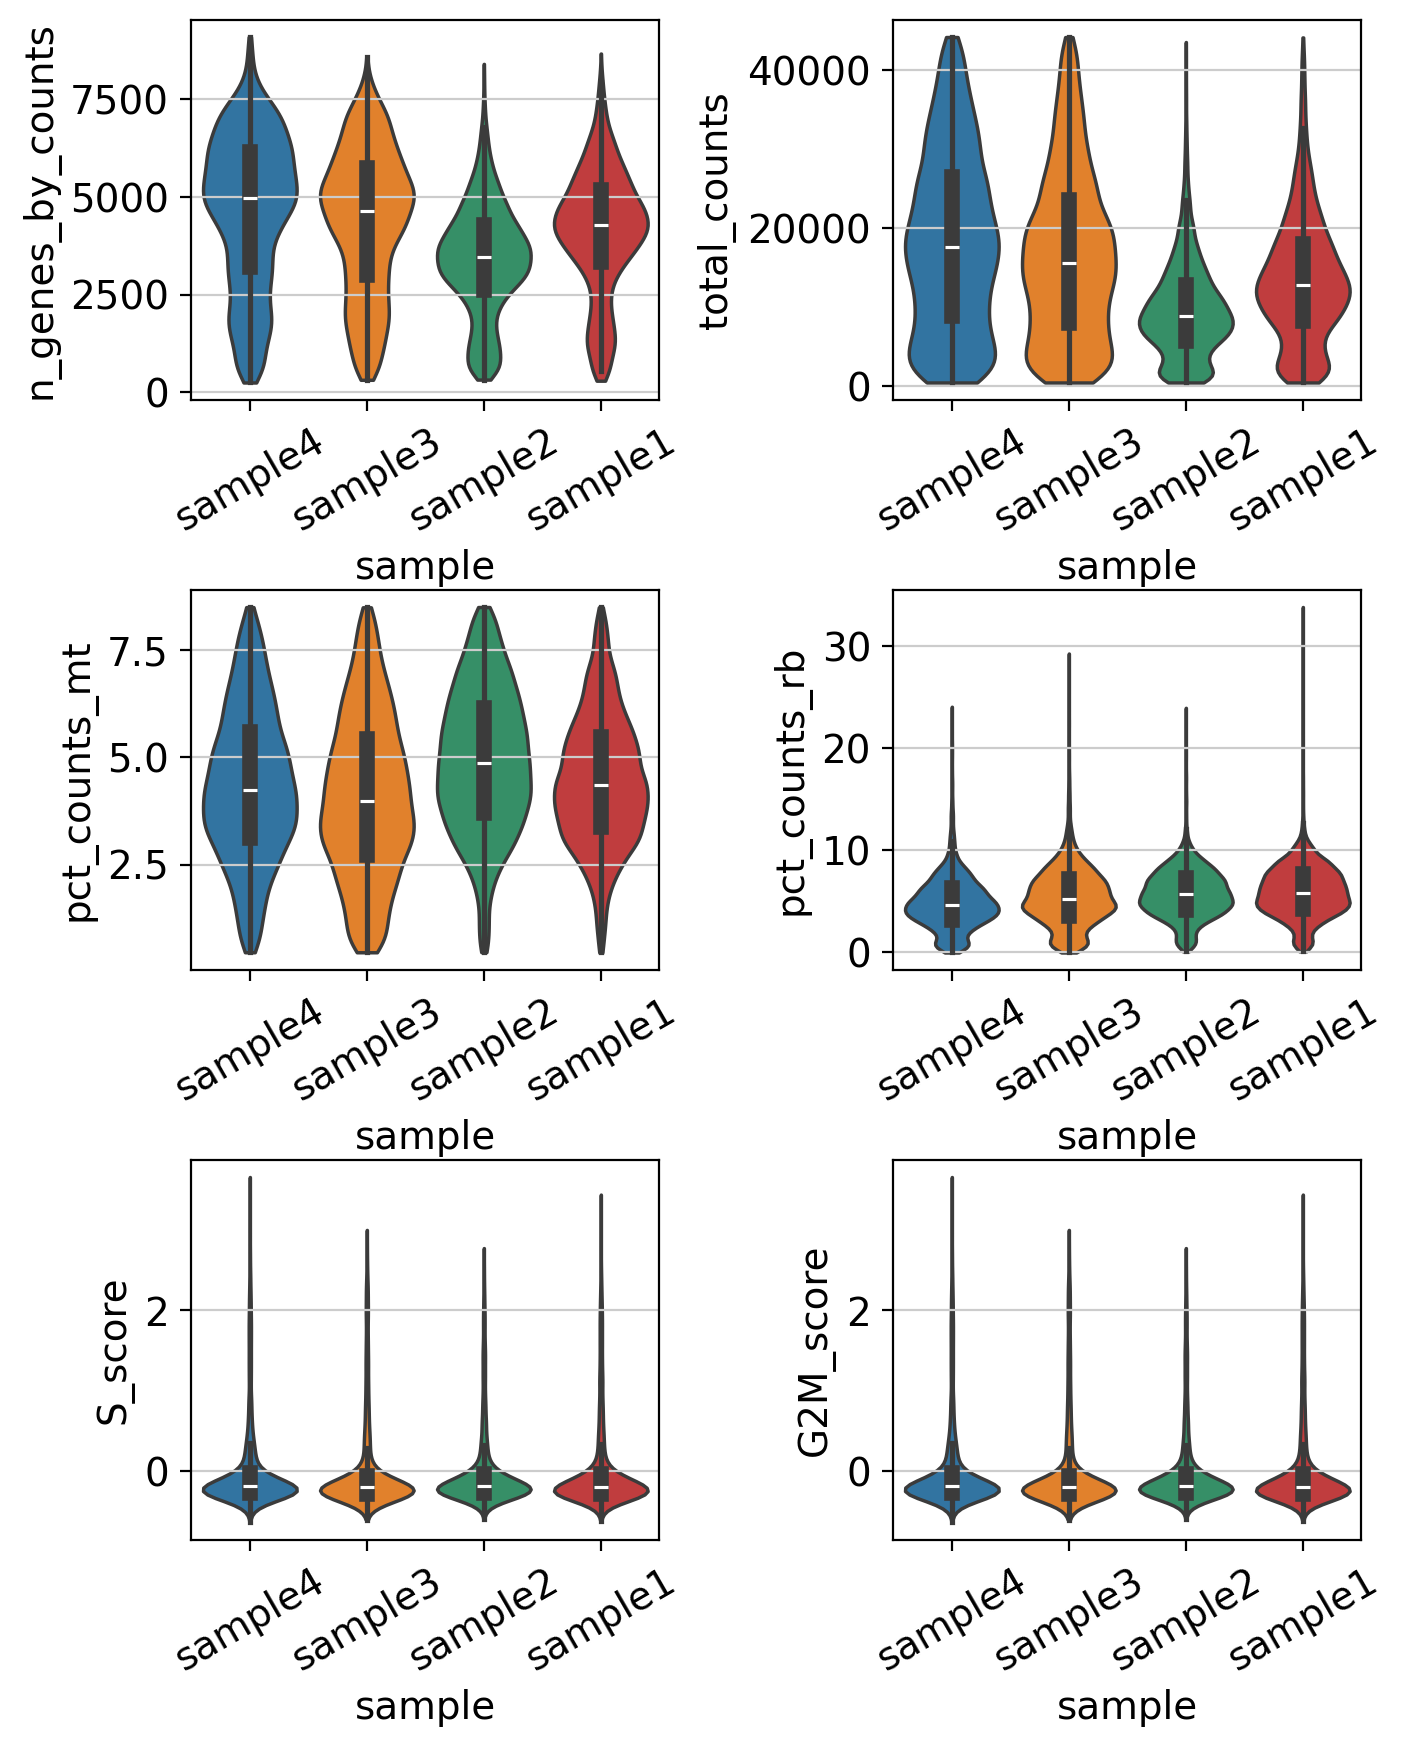

<Figure size 400x400 with 0 Axes>

In [48]:
fig, axs = pf.create_panel_fig(total_plots=len(plotting_qc_keys))

# Prevent the subplots from showing
plt.close(fig)

for i, key in enumerate(plotting_qc_keys):
    sc.pl.violin(
        adata, keys=[key], groupby="sample", stripplot=False, inner="box", ax=axs[i]
    )
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=30)

plt.tight_layout()
display(fig)

## Table of basic QC metrics

In [44]:
df1 = adata.obs.groupby("sample")[plotting_qc_keys].agg(["mean", "median"]).round(3)
df2 = adata.obs.groupby("sample")[["sample"]].agg(["size"])
itables.show(pd.concat([df1, df2], axis=1))

## Histograms

### Interactive

In [78]:
# | echo: false
# | warning: false


sample_fig_list = []
hvplot.extension("bokeh")
figs = []
df = adata.obs[plotting_qc_keys]
for key in df.columns:
    fig = (
        adata.obs[[key, "sample"]]
        .hvplot(
            kind="hist",
            bins=300,
            width=400,
            height=350,
            by="sample",
            line_color=None,
            bgcolor="white",
            shared_axes=False,
        )
        .opts(axiswise=True)
    )
    figs.append(fig)

layout = reduce(add, figs)
layout = layout.cols(2)
sample_fig_list.append(("All samples", layout))

samples = adata.obs["sample"].unique()
samples = np.sort(samples)
for sample in samples:
    figs = []
    df = adata.obs.loc[adata.obs["sample"] == sample, plotting_qc_keys]
    for key in df.columns:
        fig = (
            df[[key]]
            .hvplot(
                kind="hist",
                bins=300,
                width=400,
                height=350,
                line_color=None,
                bgcolor="white",
                shared_axes=False,
            )
            .opts(axiswise=True)
        )
        figs.append(fig)
    layout = reduce(add, figs)
    layout = layout.cols(2)
    sample_fig_list.append((sample, layout))


pn.Tabs(*sample_fig_list)

BokehModel(combine_events=True, render_bundle={'docs_json': {'61b4c55f-20cb-47df-b490-007b40abc092': {'version…

### Static

In [3]:
figs = []

ls = []
# Plot a histogram on each subplot
for i, col in enumerate(plotting_qc_keys):
    with rc_context(rc={"figure.figsize": (4, 3)}):
        fig, ax = plt.subplots()
        sns.histplot(data=adata.obs, x=col, hue="sample", bins=300, ax=ax)
        sns.move_legend(ax, "best", bbox_to_anchor=(1, 1))
        plt.setp(ax.get_legend().get_texts(), fontsize="10")  # for legend text
        plt.setp(ax.get_legend().get_title(), fontsize="10")  # for legend title
        plt.tight_layout()
        ls.append(pn.pane.Matplotlib(fig))
        plt.close(fig)

layout = pn.GridBox(*ls, ncols=2)
# layout = layout.cols(2)
figs.append(("All samples", layout))


# figs.append(("All Samples", pn.pane.Matplotlib(fig)))


samples = adata.obs["sample"].unique()
samples = np.sort(samples)
for sample in samples:
    df = adata.obs.loc[adata.obs["sample"] == sample, plotting_qc_keys]
    fig, axs = pf.create_panel_fig(total_plots=len(plotting_qc_keys))

    # Plot a histogram on each subplot
    for i, col in enumerate(plotting_qc_keys):
        adata.obs[col].plot(kind="hist", ax=axs[i], bins=300)
    plt.tight_layout()
    figs.append((sample, pn.pane.Matplotlib(fig)))
    plt.close(fig)

pn.Tabs(*figs)

NameError: name 'plotting_qc_keys' is not defined

## Scatter plots of confounders

In [ ]:
# | echo: false
# | warning: false

df = adata.obs[plotting_qc_keys + ["sample"]]
fig, axs = pf.create_panel_fig(total_plots=len(plotting_qc_keys), figsize=4)


sns.scatterplot(
    df, x="total_counts", y="n_genes_by_counts", hue="sample", alpha=0.4, s=6, ax=axs[0]
)
axs[0].legend(fancybox=True, framealpha=0.8)
sns.scatterplot(
    df, x="total_counts", y="pct_counts_mt", hue="sample", alpha=0.4, s=6, ax=axs[1]
)
axs[1].legend(fancybox=True, framealpha=0.8)
sns.scatterplot(
    df, x="total_counts", y="pct_counts_rb", hue="sample", alpha=0.4, s=6, ax=axs[2]
)
axs[2].legend(fancybox=True, framealpha=0.8)
sns.move_legend(axs[0], "upper left", bbox_to_anchor=(1, 1))
sns.move_legend(axs[1], "upper left", bbox_to_anchor=(1, 1))
sns.move_legend(axs[2], "upper left", bbox_to_anchor=(1, 1))

if FILTER_DOUBLETS:
    sns.scatterplot(
        df, x="total_counts", y="doublet_score", hue="sample", alpha=0.4, s=6, ax=axs[3]
    )
    sns.move_legend(axs[3], "upper left", bbox_to_anchor=(1, 1))

if CORRECT_AMBIENT_RNA:
    sns.scatterplot(
        df,
        x="total_counts",
        y="decontX_contamination",
        hue="sample",
        alpha=0.4,
        s=6,
        ax=axs[4],
    )
    sns.move_legend(axs[4], "upper left", bbox_to_anchor=(1, 1))

for i, ax in enumerate(axs):
    if not ax.has_data():
        ax.set_visible(False)

plt.tight_layout()

## DeconX contamination

In [ ]:
# | echo: false
# | warning: false

# TODO: Test this plot
if CORRECT_AMBIENT_RNA and TECHNOLOGY == "10x":
    fig, axs = pf.create_panel_fig(total_plots=2, figsize=4)
    scatter = sns.scatterplot(
        pd.concat([adata.obsm["decontX_UMAP"], adata.obs], axis=1),
        x="DecontX_UMAP_1",
        y="DecontX_UMAP_2",
        hue="decontX_contamination",
        s=0.8,
        ax=axs[0],
        palette="inferno",
    )
    sns.move_legend(
        scatter, "center right", bbox_to_anchor=(1.2, 0.5), title=None, frameon=False
    )

    scatter = sns.scatterplot(
        pd.concat([adata.obsm["decontX_UMAP"], adata.obs], axis=1),
        x="DecontX_UMAP_1",
        y="DecontX_UMAP_2",
        hue="decontX_clusters",
        s=0.8,
        ax=axs[1],
    )
    sns.move_legend(
        scatter, "center right", bbox_to_anchor=(1.2, 0.5), title=None, frameon=False
    )

    plt.tight_layout()

## Effects of confounders

In [164]:
# | echo: false
# | output: false
# | warning: false

sc.pp.pca(adata, n_comps=30)
sc.pp.neighbors(adata)
sc.tl.leiden(adata, key_added="groups", flavor="leidenalg")
sc.tl.umap(adata)

In [ ]:
# | echo: false
# | warning: false
figs = sc.pl.umap(
    adata,
    size=7,
    color=["sample"] + plotting_qc_keys,
    show=False,
    ncols=2,
    color_map="inferno",
    sort_order=False,
    alpha=0.8,
    hspace=0.2,
    wspace=0.3,
)


# Filtering 

## Filtering thresholds

In [ ]:
# | echo: false
# | warning: false

ls = {}
for key in filter_qc_keys:
    ls[key] = (
        adata.obs.query(f"{key}_outlier == False").groupby("sample")[key].agg("min")
    )
min_df = pd.concat(ls, axis=1)

for key in filter_qc_keys:
    ls[key] = (
        adata.obs.query(f"{key}_outlier == False").groupby("sample")[key].agg("max")
    )
max_df = pd.concat(ls, axis=1)

pd.concat([min_df, max_df], keys=["min", "max"], axis=0)

## Number of outliers based on provided criteria

In [ ]:
# | echo: false
# | warning: false

# TODO: Fix
# df_l = []
# col_l = []
# for key in filter_qc_keys:
#     try:
#         df_l.append(
#             pd.DataFrame(
#                 adata.obs[[f"{key}_outlier", "sample"]].value_counts().loc[(True), :]
#             )
#         )
#         col_l.append(f"{key}_outlier")
#     except:
#         pass

# col_l.append("aggregate outliers")
# df_l.append(
#     pd.DataFrame(adata.obs[["outlier", "sample"]].value_counts().loc[(True), :])
# )

# df_l.append(pd.DataFrame(adata.obs[["sample"]].value_counts()))
# df_l[-1].index = df_l[-1].index.get_level_values(0)
# col_l.append("Total Cells")

# df = pd.concat(df_l, axis=1)
# df.columns = [col_l]
# df = df.loc[np.sort(df.index), :]
# itables.show(df.fillna(0))

## Cell filtering based on outlier function

In [ ]:
# | echo: false
# | output: false
# | warning: false

adata.obs = adata.obs.infer_objects()

# Saving The object at the last step before subsseting
if path.exists(DIR_SAVE):
    adata.write_h5ad(path.join(DIR_SAVE, "raw_adata.h5ad"))
else:
    mkdir(DIR_SAVE)
    adata.write_h5ad(path.join(DIR_SAVE, "raw_adata.h5ad"))

# Cell Filtering based on threshold


adata = adata[(~adata.obs.outlier)].copy()

# QC plots (post filtering)

## Table of basic QC metrics

In [ ]:
# | echo: false
# | warning: false

df1 = adata.obs.groupby("sample")[plotting_qc_keys].agg(["mean", "median"]).round(3)
df2 = adata.obs.groupby("sample")[["sample"]].agg(["size"])
df = pd.concat([df1, df2], axis=1)
df

## Histograms

### Interactive

In [ ]:
# | echo: false
# | warning: false


from operator import add

sample_fig_list = []
hvplot.extension("bokeh")
ls = []
df = adata.obs[plotting_qc_keys]
for key in df.columns:
    fig = (
        adata.obs[[key, "sample"]]
        .hvplot(
            kind="hist",
            bins=300,
            width=400,
            height=350,
            by="sample",
            line_color=None,
            bgcolor="white",
            shared_axes=False,
        )
        .opts(axiswise=True)
    )
    ls.append(fig)

layout = reduce(add, ls)
layout = layout.cols(2)
sample_fig_list.append(("All samples", layout))

samples = adata.obs["sample"].unique()
samples = np.sort(samples)
for sample in samples:
    ls = []
    df = adata.obs.loc[adata.obs["sample"] == sample, plotting_qc_keys]
    for key in df.columns:
        fig = (
            df[[key]]
            .hvplot(
                kind="hist",
                bins=300,
                width=400,
                height=350,
                line_color=None,
                bgcolor="white",
                shared_axes=False,
            )
            .opts(axiswise=True)
        )
        ls.append(fig)
    layout = reduce(add, ls)
    layout = layout.cols(2)
    sample_fig_list.append((sample, layout))


pn.Tabs(*sample_fig_list)

### Static

In [ ]:
figs = []

ls = []
# Plot a histogram on each subplot
for i, col in enumerate(plotting_qc_keys):
    with rc_context(rc={"figure.figsize": (4, 3)}):
        fig, ax = plt.subplots()
        sns.histplot(data=adata.obs, x=col, hue="sample", bins=300, ax=ax)
        sns.move_legend(ax, "best", bbox_to_anchor=(1, 1))
        plt.setp(ax.get_legend().get_texts(), fontsize="10")  # for legend text
        plt.setp(ax.get_legend().get_title(), fontsize="10")  # for legend title
        plt.tight_layout()
        ls.append(pn.pane.Matplotlib(fig))
        plt.close(fig)

layout = pn.GridBox(*ls, ncols=2)
# layout = layout.cols(2)
figs.append(("All samples", layout))


# figs.append(("All Samples", pn.pane.Matplotlib(fig)))


samples = adata.obs["sample"].unique()
samples = np.sort(samples)
for sample in samples:
    df = adata.obs.loc[adata.obs["sample"] == sample, plotting_qc_keys]
    fig, axs = pf.create_panel_fig(total_plots=len(plotting_qc_keys))

    # Plot a histogram on each subplot
    for i, col in enumerate(plotting_qc_keys):
        adata.obs[col].plot(kind="hist", ax=axs[i], bins=300)
    plt.tight_layout()
    figs.append((sample, pn.pane.Matplotlib(fig)))
    plt.close(fig)

pn.Tabs(*figs)

## Scatter plots of confounders after filtering

In [ ]:
# | echo: false
# | warning: false

# Assuming 'df' is your DataFrame
df = adata.obs[plotting_qc_keys + ["sample"]]
fig, axs = pf.create_panel_fig(total_plots=len(df.columns), figsize=4)

sns.scatterplot(
    df, x="total_counts", y="n_genes_by_counts", hue="sample", alpha=0.4, s=6, ax=axs[0]
)
axs[0].legend(fancybox=True, framealpha=0.8)
sns.scatterplot(
    df, x="total_counts", y="pct_counts_mt", hue="sample", alpha=0.4, s=6, ax=axs[1]
)
axs[1].legend(fancybox=True, framealpha=0.8)
sns.scatterplot(
    df, x="total_counts", y="pct_counts_rb", hue="sample", alpha=0.4, s=6, ax=axs[2]
)
axs[2].legend(fancybox=True, framealpha=0.8)
sns.move_legend(axs[0], "upper left", bbox_to_anchor=(1, 1))
sns.move_legend(axs[1], "upper left", bbox_to_anchor=(1, 1))
sns.move_legend(axs[2], "upper left", bbox_to_anchor=(1, 1))

if FILTER_DOUBLETS:
    sns.scatterplot(
        df, x="total_counts", y="doublet_score", hue="sample", alpha=0.4, s=6, ax=axs[3]
    )
    sns.move_legend(axs[3], "upper left", bbox_to_anchor=(1, 1))

if CORRECT_AMBIENT_RNA:
    sns.scatterplot(
        df,
        x="total_counts",
        y="decontX_contamination",
        hue="sample",
        alpha=0.4,
        s=6,
        ax=axs[4],
    )
    sns.move_legend(axs[4], "upper left", bbox_to_anchor=(1, 1))

[ax.set_visible(False) for ax in axs.flatten() if not ax.has_data()]
plt.tight_layout()

## DecontX contamination

In [ ]:
# | echo: false
# | warning: false

if CORRECT_AMBIENT_RNA and TECHNOLOGY == "10x":
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    scatter = sns.scatterplot(
        pd.concat([adata.obsm["decontX_UMAP"], adata.obs], axis=1),
        x="DecontX_UMAP_1",
        y="DecontX_UMAP_2",
        hue="decontX_contamination",
        s=0.8,
        ax=ax1,
        palette="inferno",
    )
    sns.move_legend(
        scatter, "center right", bbox_to_anchor=(1.1, 0.5), title=None, frameon=False
    )

    scatter = sns.scatterplot(
        pd.concat([adata.obsm["decontX_UMAP"], adata.obs], axis=1),
        x="DecontX_UMAP_1",
        y="DecontX_UMAP_2",
        hue="decontX_clusters",
        s=0.8,
        ax=ax2,
    )
    sns.move_legend(
        scatter, "center right", bbox_to_anchor=(1.15, 0.5), title=None, frameon=False
    )

    plt.tight_layout()

In [ ]:
if CORRECT_AMBIENT_RNA and TECHNOLOGY == "10x":
    with rc_context(
        {
            "figure.figsize": (
                adata.obs["decontX_clusters"].astype("int32").max() * 0.7,
                5,
            )
        }
    ):
        sns.violinplot(adata.obs, x="decontX_clusters", y="decontX_contamination")
        sns.stripplot(
            adata.obs, x="decontX_clusters", y="decontX_contamination", s=1, c="black"
        )

## Clustering after to cell filtering

In [ ]:
# | echo: false
# | output: false
# | warning: false

sc.pp.pca(adata, n_comps=30)
sc.pp.neighbors(adata)
sc.tl.leiden(adata, key_added="groups", flavor="leidenalg")
sc.tl.umap(adata)

In [ ]:
# | echo: false
# | warning: false
with rc_context({"figure.figsize": (5, (len(plotting_qc_keys) + 1) * 0.6)}):
    figs = sc.pl.umap(
        adata,
        size=8,
        color=["sample"] + plotting_qc_keys,
        show=False,
        ncols=2,
        color_map="inferno",
        sort_order=False,
        alpha=0.8,
        hspace=0.2,
        wspace=0.3,
    )

In [ ]:
# | echo: false
# | output: false
# | warning: false

adata.obs = adata.obs.infer_objects()
## Save Result
if path.exists(DIR_SAVE):
    adata.write_h5ad(path.join(DIR_SAVE, "adata.h5ad"))
else:
    mkdir(DIR_SAVE)
    adata.write_h5ad(path.join(DIR_SAVE, "adata.h5ad"))

# Session Information

In [ ]:
session_info.show()